# Homeworlds
Emily Nusbaum, Maxwell Silverman, Patrick O'Toole

## Introduction:
Homeworlds is a niche asymmetric strategy board game. It uses a set of plastic pyramids of three different sizes (small: 1, medium: 2, large: 3) and four different colors (blue, green, red, yellow). The players take turns making a single action of their choice (i.e. build, trade, move, discover, or attack) based on the colors of the pyramids on the table. The players can also sacrifice one of their pyramids on their turn to take multiple actions on this turn. The game always begins with the first player choosing a set of any three pyramids to be their “homeworld.” Then the second player does the same. The goal of the game is to take control of or destroy your opponents homeworld.

For the purpose of this project, it is only necessary to understand that homeworlds are made up of three different pyramids. The colors and sizes of these worlds are important to how the player plays the game, but it is not necessary to understand the complexities of the game to understand this project (however, if you're curious, the game instructions are with our additional resources).

## Motivation:
We want to explore whether or not the winner of a Homeworlds game can be predicted based on factors such as who goes first, what setups are used, and if additional actions are taken during a turn. The goal is to determine if the game is influenced by these external factors, or if the outcome is seemingly random, implying that the game is fair.

## Data Curation:
We begin by collecting data from SuperDuperGames.org, which hosts data from every homeworlds game played on the site. Because the data is only accessible if a user is logged in, we created a payload to create a new session with the requests library to login with the given credentials. We used a post request to send the payload to the site and a get request to get the web page. SuperDuperGames assigns the participants to one of four positions: north, south, east, west. If there are only two players, there will only be north and south participants. If three, there will be north, south, and east.

In [1]:
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd
import datetime
from datetime import datetime as dt
import numpy as np
import enum
import re
import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as cbn
from scipy import stats
from statsmodels.stats import weightstats as stests
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

#!conda install -y html5lib
#!conda install -y lxml

In [2]:
# Pretending to be a safari browser, shhhhh...
comp_head = {'User-Agent':'Safari/13.1'}

# Create an auth payload to login to the site.
payload = {
    'mode': 'auth',
    'username': 'fall2020cmsc320',
    'password': 'BGtz0jo4',
    'cookies': {}
}

# Use auth payload to create a session through which I can access the data from this account.
with requests.Session() as sess:
    auth_post = sess.post('http://superdupergames.org/', data=payload)
    games_page = sess.get('http://superdupergames.org/pgn.html?id=homeworlds', headers=comp_head).content

In [3]:
# Output the content of the webpage with said data.
print(games_page[:1000])

b'<!DOCTYPE html\nPUBLIC "-//W3C//DTD XHTML 1.0 Frameset//EN"\n"http://www.w3.org/TR/xhtml1/DTD/xhtml1-frameset.dtd">\n\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">\n\n<head>\n\t<link rel="stylesheet" type="text/css" href="/styles.css" />\n\n\n\n\t<title>Super Duper Games - PGN Viewer</title>\n\t<META HTTP-EQUIV="Pragma" CONTENT="no-cache">\n\t<META HTTP-EQUIV="Expires" CONTENT="-1">\n</head>\n\n<body>\n\t<table class="help">\n\t\t<tr class="help">\n\t\t\t<td class="help"><pre>Homeworlds Online (SDG# 651)\nStarted: 2005.9.8, Ended: 2005.9.10\nParticipants: rbryan (S), crackity_jones (N)\nWinner: rbryan\n\n\trbryan: howdy\n\tSYSTEM: crackity_jones resigns.\n\nHomeworlds Online (SDG# 632)\nStarted: 2005.9.6, Ended: 2005.9.7\nParticipants: Subhan64 (S), jesse (N)\nWinner: jesse\n\n1) jesse: Homeworld B2 Y1 G3\n\n2) Subhan64: Homeworld Y2 B2 R2\n\tjesse: Greetings to all intelligent life forms.  We come in peace.\n\n3) jesse: Pass\n\n4) Subhan64: Trade R2 G2 Subhan6

## Parsing:
We began parsing the data using Beautiful Soup to find the "pre" tag that contained all of the text. On the webpage, each game starts with a header containing data such as the game ID number, start date time, end date time, etc. We used this to split the data into a list of strings each of which contains the text for 1 game. We then created various classes to model the different pieces and actions of the game, as well as the games themselves. Finally, we converted the raw strings to instances of these objects before using them to create dataframes containing data on all of the games.

In [4]:
# Use beautiful soup to find the pre tag within which the datalines are.
souped_games = BeautifulSoup(games_page, 'html')
game_outline = souped_games.find('pre').text

# Each game outline starts with a header containing the game ID, start date, end date, etc. The header opens with 'Homeworlds Online (SDG# ' so we split the string containing the outlines of all of the games into a list of strings each containing the outlines of one game.
game_lst = game_outline.split('Homeworlds Online (SDG# ')[1:]        

#Print out a game to check
print(game_lst[1])

632)
Started: 2005.9.6, Ended: 2005.9.7
Participants: Subhan64 (S), jesse (N)
Winner: jesse

1) jesse: Homeworld B2 Y1 G3

2) Subhan64: Homeworld Y2 B2 R2
	jesse: Greetings to all intelligent life forms.  We come in peace.

3) jesse: Pass

4) Subhan64: Trade R2 G2 Subhan64
	jesse: You must be new. It is vital to have green in your home system at the start of the game. You can't use red until our forces come into contact.  You can't use yellw until you have another ship to leave in your home system.  You can use blue to change the color of your ship, but in that case you should have started with the new color to begin with.  I'll give you a chance to change to green now.
	jesse: It is also very important to start with a large ship, rather than a medium. Large ships are power. Without one, you will be weak on both offense and defense.

5) jesse: Build G1 Jesse

6) Subhan64: Build G1 Subhan64

7) jesse: Trade G1 R1 Jesse

8) Subhan64: Discover G1 Subhan64 R1 Abraxis

9) jesse: Build R1 Je

In [5]:
# Defines a class for a single game piece. Each game piece consists of one color from blue (B), green (G), red (R), yellow(Y) as well as one size from 1, 2, 3.
class Piece:
    def __init__(self, data):
        self.color = data[0]
        self.size = data[1]
    def __str__(self):
        return self.color + str(self.size)

In [6]:
# Defines an enum that describes which of the possible actions that can be taken on a turn
class ActionType(enum.Enum):
    BUILD = 1           # Player builds a new piece.
    MOVE = 2            # Player moves a piece to a discovered star system.
    TRADE = 3           # Player trades a piece for a piece of a different color, but the same size.
    ATTACK = 4          # Player attacks an opponents piece
    SACRIFICE = 5       # Player sacrifices a piece and takes a number of extra actions equal to the size of the sacrificed piece.
    HOMEWORLD = 6       # Player sets up their homeworld.
    PASS = 7            # Player passes instead of taking an action.
    DISCOVER = 8        # Player moves piece to a new star system
    CATASTROPHE = 9     # Player ends their turn by calling a catastrophe
    
# Helper function to translate a string into an ActionType enum.
def str_to_action(action_str):
    if action_str == "Build":
        return ActionType.BUILD
    if action_str == "Move":
        return ActionType.MOVE
    if action_str == "Trade":
        return ActionType.TRADE
    if action_str == "Attack":
        return ActionType.ATTACK
    if action_str == "Sacrifice":
        return ActionType.SACRIFICE
    if action_str == "Homeworld":
        return ActionType.HOMEWORLD
    if action_str == "Pass":
        return ActionType.PASS
    if action_str == "Discover":
        return ActionType.DISCOVER
    if action_str == "Catastrophe":
        return ActionType.CATASTROPHE
    
# Helper function to translate ActionType enums into the respective string.
def action_to_str(action):
    if action == ActionType.BUILD:
        return "Build"
    if action == ActionType.MOVE:
        return "Move"
    if action == ActionType.TRADE:
        return "Trade"
    if action == ActionType.ATTACK:
        return "Attack"
    if action == ActionType.SACRIFICE:
        return "Sacrifice"
    if action == ActionType.HOMEWORLD:
        return "Homeworld"
    if action == ActionType.PASS:
        return "Pass"
    if action == ActionType.DISCOVER:
        return "Discover"
    if action == ActionType.CATASTROPHE:
        return "Catastrophe"

In [7]:
# Defines a class representing a single action that contains the current turn number, the player taking the action, the action type, and any extra parameters relevant to the action type.
class Action:
    def __init__(self, turn_num, player, action, params):
        self.turn_num = turn_num
        self.action = action
        self.player = player
        self.params = params
    def __str__(self):
        ret = str(self.turn_num) + ") " + self.player + ": " + action_to_str(self.action)
        for i in self.params:
            ret += " " + str(i)
        return ret

# A helper function that takes in a list representing a single game containing strings each representing a line from the game outline from the site.
def parse_turn(game_lines):
    # Define regex for each action type
    build_turn = re.match("^(\d+)\) (\S+): (Build|B|Construct|C) ([RGBY][1-4]) (\S+)$", game_lines[0])
    discover_turn = re.match("^(\d+)\) (\S+): (Discover|D) ([RGBY][1-4]) (\S+) ([RGBY][1-4]) (\S+)$", game_lines[0])
    move_turn = re.match("^(\d+)\) (\S+): (Move|M) ([RGBY][1-4]) (\S+) (\S+)$", game_lines[0])
    trade_turn = re.match("^(\d+)\) (\S+): (Trade|T) ([RGBY][1-4]) ([RGBY][1-4]) (\S+)$", game_lines[0])
    attack_turn = re.match("^(\d+)\) (\S+): (Attack|A) ([RGBY][1-4])([NS]) (\S+)$", game_lines[0])
    homeworld_turn = re.match("^(\d+)\) (\S+): (Homeworld|H) ([RGBY][1-4]) ([RGBY][1-4]) ([RGBY][1-4])", game_lines[0])
    pass_turn = re.match("^(\d+)\) (\S+): (Pass|P)$", game_lines[0])
    sacrifice_turn = re.match("^(\d+)\) (\S+): (Sacrifice|S) ([RGBY][1-4]) (\S+)$", game_lines[0])
    
    # If the string matches a certain pattern 
    if build_turn != None:
        ret = [Action(int(build_turn.group(1)), build_turn.group(2), ActionType.BUILD,
                     [Piece(build_turn.group(4)), build_turn.group(5)])], game_lines[1:]
    elif discover_turn != None:
        ret = [Action(int(discover_turn.group(1)), discover_turn.group(2), ActionType.DISCOVER,
                     [Piece(discover_turn.group(4)), discover_turn.group(5), Piece(discover_turn.group(6)),
                      discover_turn.group(7)])], game_lines[1:]
    elif move_turn != None:
        ret = [Action(int(move_turn.group(1)), move_turn.group(2), ActionType.MOVE,
                     [Piece(move_turn.group(4)), move_turn.group(5), move_turn.group(6)])], game_lines[1:]
    elif trade_turn != None:
        ret = [Action(int(trade_turn.group(1)), trade_turn.group(2), ActionType.TRADE,
                     [Piece(trade_turn.group(4)), Piece(trade_turn.group(5)),
                      trade_turn.group(6)])], game_lines[1:]
    elif attack_turn != None:
        ret = [Action(int(attack_turn.group(1)), attack_turn.group(2), ActionType.ATTACK,
                     [Piece(attack_turn.group(4)), attack_turn.group(5), attack_turn.group(6)])], game_lines[1:]
        
    elif homeworld_turn != None:
        ret = [Action(int(homeworld_turn.group(1)), homeworld_turn.group(2), ActionType.HOMEWORLD,
                     [Piece(homeworld_turn.group(4)), Piece(homeworld_turn.group(5)),
                      Piece(homeworld_turn.group(6))])], game_lines[1:]
        
    elif pass_turn != None:
        ret = [Action(int(pass_turn.group(1)), pass_turn.group(2), ActionType.PASS, [])], game_lines[1:]
    elif sacrifice_turn != None:
        ret = [Action(int(sacrifice_turn.group(1)), sacrifice_turn.group(2), ActionType.SACRIFICE,
                    [Piece(sacrifice_turn.group(4)), sacrifice_turn.group(5)])]
        for i in range(0, int(sacrifice_turn.group(4)[1])):
            game_lines = game_lines[1:]
            sac_turn = re.match("^(Build|B|Construct|C) ([RGBY][1-4]) (\S+)$", game_lines[0])
            if sac_turn != None:
                ret.append(Action(int(sacrifice_turn.group(1)), sacrifice_turn.group(2), ActionType.BUILD,
                                [Piece(sac_turn.group(2)), sac_turn.group(3)]))

            sac_turn = re.match("^(Discover|D) ([RGBY][1-4]) (\S+) ([RGBY][1-4]) (\S+)$", game_lines[0])
            if sac_turn != None:
                ret.append(Action(int(sacrifice_turn.group(1)), sacrifice_turn.group(2), ActionType.DISCOVER,
                                [Piece(sac_turn.group(2)), sac_turn.group(3), Piece(sac_turn.group(4)),
                                 sac_turn.group(4)]))
                
            sac_turn = re.match("^(Move|M) ([RGBY][1-4]) (\S+) (\S+)$", game_lines[0])
            if sac_turn != None:
                ret.append(Action(int(sacrifice_turn.group(1)), sacrifice_turn.group(2), ActionType.MOVE,
                               [Piece(sac_turn.group(2)), sac_turn.group(3), sac_turn.group(4)]))

            sac_turn = re.match("^(Trade|T) ([RGBY][1-4]) ([RGBY][1-4]) (\S+)$", game_lines[0])
            if sac_turn != None:
                ret.append(Action(int(sacrifice_turn.group(1)), sacrifice_turn.group(2), ActionType.TRADE,
                                [Piece(sac_turn.group(2)), Piece(sac_turn.group(3)), sac_turn.group(4)]))

            sac_turn = re.match("^(Attack|A) ([RGBY][1-4])([NS]) (\S+)$", game_lines[0])
            if sac_turn != None:
                ret.append(Action(int(sacrifice_turn.group(1)), sacrifice_turn.group(2), ActionType.ATTACK,
                                [Piece(sac_turn.group(2)), sac_turn.group(3), sac_turn.group(4)]))

            sac_turn = re.match("^(Pass|P)$", game_lines[0])
            if sac_turn != None:
                ret.append(Action(int(sacrifice_turn.group(1)), sacrifice_turn.group(2), ActionType.PASS, []))
        ret = ret, game_lines[1:]
    else: # If it does not match any of these, assume it is a chat line and return None.
        ret = None, game_lines[1:]
    
    ret0, ret1 = ret
    if len(game_lines) > 1 and ret0 != None:
        cat_turn = re.match("^Catastrophe (\S+) ([RGBY])$", game_lines[1])
        if cat_turn != None:
            ret0.append(Action(ret0[0].turn_num, ret0[0].player, ActionType.CATASTROPHE, [cat_turn.group(1), cat_turn.group(2)]))
            ret = ret0, game_lines[2:]
    
    return ret # Returns a list of the actions in this turn and the remaining game lines for this game.

In [8]:
# Defines the Game class (representing an entire game of homeworlds). The init takes in the string of text for the current game (including header and turns).
class Game:
    def __init__(self, game_str):
        x = 0
        game_lines = game_str.split('\n')
        game_match = re.match('\d+', game_lines[x]) # Parse game number
        self.game_no = int(game_match.group(0))
        x+=1
        
        game_match = re.search('Variants: .+', game_lines[x]) # Ignore variants
        if game_match != None:
            self.has_variants = True
            self.variants = game_match.group(0)[10:]
            x+=1
        else:
            self.has_variants = False
        
        game_match = re.search('Started: \d+.\d+.\d+', game_lines[x]) # Parse start date time
        self.game_start = dt.strptime(game_match.group(0)[9:], '%Y.%m.%d')
        game_match = re.search('Ended: \d+.\d+.\d+', game_lines[x]) # Parse end date time
        self.game_end = dt.strptime(game_match.group(0)[7:], '%Y.%m.%d')
        x+=1
        
        # Parse participants
        game_match = re.search('Participants: (\S+ \([NESW]\))(, (\S+) \([NESW]\))+', game_lines[x])
        self.north_part = np.nan
        self.east_part = np.nan
        self.west_part = np.nan
        self.south_part = np.nan
        self.num_parts = 2
        for i in game_match.groups(): # Set north, east, south, and west participants
            tmp = re.search("(, )?(\S+) \(([NESW])\)", i)
            if tmp != None:
                if tmp.group(3) == "N":
                    self.north_part = tmp.group(2)
                elif tmp.group(3) == "E":
                    self.num_parts += 1
                    self.east_part = tmp.group(2)
                elif tmp.group(3) == "W":
                    self.num_parts += 1
                    self.west_part = tmp.group(2)
                elif tmp.group(3) == "S":
                    self.south_part = tmp.group(2)
        x+=1
        
        # Parse winner of the game
        game_match = re.search('Winner: \S+', game_lines[x])
        self.winner = game_match.group(0)[8:]
        x+=1
        
        game_lines = game_lines[x:]

        # Parse the total number of turns
        self.num_turns = 0
        for j in range(len(game_lines)-1, 0, -1):
            last_turn_num = re.search("^(\d+)\)", game_lines[j])
            if last_turn_num != None:
                self.num_turns = int(last_turn_num.group(1))
                break
        self.actions = []
        
        # Parse the next single-turn-worth of actions and append them to the list of actions until there are no more game_lines left.
        while len(game_lines) > 0:
            turns, game_lines = parse_turn(game_lines)
            if turns != None:
                for j in turns:
                    self.actions.append(j)
        self.num_actions = len(self.actions)
        self.player_actions = {'north': 0, 'south': 0, 'east': 0, 'west': 0}
        for i in self.actions: # Create dictionary with number of actions per player
            if i.player == self.north_part:
                self.player_actions['north'] += 1
            if i.player == self.south_part:
                self.player_actions['south'] += 1
            if i.player == self.east_part:
                self.player_actions['east'] += 1
            if i.player == self.west_part:
                self.player_actions['west'] += 1
        self.player_hw = {'north': np.nan, 'south': np.nan, 'east': np.nan, 'west': np.nan}
        if self.num_actions >= 4: # Create dictionary with each player's homeworld setup.
            if self.num_parts == 2:
                to_set = 2
                curr = 0
                while(to_set > 0 and curr < self.num_actions):
                    if self.actions[curr].action == ActionType.HOMEWORLD:
                        if self.actions[curr].player == self.north_part:
                            self.player_hw['north'] = str(self.actions[curr].params[0]) + " " + str(self.actions[curr].params[1]) + " " + str(self.actions[curr].params[2])
                        else:
                            self.player_hw['south'] = str(self.actions[curr].params[0]) + " " + str(self.actions[curr].params[1]) + " " + str(self.actions[curr].params[2])
                        to_set -= 1
                    curr += 1
            elif self.num_parts == 3:
                to_set = 3
                curr = 0
                while(to_set > 0 and curr < self.num_actions):
                    if self.actions[curr].action == ActionType.HOMEWORLD:
                        if self.actions[curr].player == self.north_part:
                            self.player_hw['north'] = str(self.actions[curr].params[0]) + " " + str(self.actions[curr].params[1]) + " " + str(self.actions[curr].params[2])
                        elif self.actions[curr].player == self.south_part:
                            self.player_hw['south'] = str(self.actions[curr].params[0]) + " " + str(self.actions[curr].params[1]) + " " + str(self.actions[curr].params[2])
                        else:
                            self.player_hw['east'] = str(self.actions[curr].params[0]) + " " + str(self.actions[curr].params[1]) + " " + str(self.actions[curr].params[2])
                        to_set -= 1
                    curr += 1
            elif self.num_parts == 4:
                to_set = 3
                curr = 0
                while(to_set > 0 and curr < self.num_actions):
                    if self.actions[curr].action == ActionType.HOMEWORLD:
                        if self.actions[curr].player == self.north_part:
                            self.player_hw['north'] = str(self.actions[curr].params[0]) + " " + str(self.actions[curr].params[1]) + " " + str(self.actions[curr].params[2])
                        elif self.actions[curr].player == self.south_part:
                            self.player_hw['south'] = str(self.actions[curr].params[0]) + " " + str(self.actions[curr].params[1]) + " " + str(self.actions[curr].params[2])
                        elif self.actions[curr].player == self.east_part:
                            self.player_hw['east'] = str(self.actions[curr].params[0]) + " " + str(self.actions[curr].params[1]) + " " + str(self.actions[curr].params[2])
                        else:
                            self.player_hw['west'] = str(self.actions[curr].params[0]) + " " + str(self.actions[curr].params[1]) + " " + str(self.actions[curr].params[2])
                        to_set -= 1
                    curr += 1
                    
        # Correctly order the setup so that "Y1 B2 G3" is the same as "B2 Y1 G3", for example.
        for i in self.player_hw:
            if isinstance(self.player_hw[i], str):
                if int(self.player_hw[i][1]) > int(self.player_hw[i][4]):
                    self.player_hw[i] = self.player_hw[i][3:5] + " " + self.player_hw[i][0:2] + " " + self.player_hw[i][6:]
                elif int(self.player_hw[i][1]) == int(self.player_hw[i][4]):
                    if (self.player_hw[i][0]) > (self.player_hw[i][3]):
                        self.player_hw[i] = self.player_hw[i][3:5] + " " + self.player_hw[i][0:2] + " " + self.player_hw[i][6:]
        self.north_action_type = {'build': 0, 'move': 0, 'discover': 0, 'trade': 0, 'attack': 0,
                                   'sacrifice': 0, 'catastrophe': 0, 'pass': 0}
        self.south_action_type = {'build': 0, 'move': 0, 'discover': 0, 'trade': 0, 'attack': 0,
                                   'sacrifice': 0, 'catastrophe': 0, 'pass': 0}
        self.east_action_type = {'build': 0, 'move': 0, 'discover': 0, 'trade': 0, 'attack': 0,
                                  'sacrifice': 0, 'catastrophe': 0, 'pass': 0}
        self.west_action_type = {'build': 0, 'move': 0, 'discover': 0, 'trade': 0, 'attack': 0,
                                  'sacrifice': 0, 'catastrophe': 0, 'pass': 0}
    
        # Calculate the number of each type of action each player does.
        for i in self.actions:
            if i.player == self.north_part:
                if i.action == ActionType.BUILD:
                    self.north_action_type['build'] += 1
                elif i.action == ActionType.MOVE:
                    self.north_action_type['move'] += 1
                elif i.action == ActionType.DISCOVER:
                    self.north_action_type['discover'] += 1
                elif i.action == ActionType.TRADE:
                    self.north_action_type['trade'] += 1
                elif i.action == ActionType.ATTACK:
                    self.north_action_type['attack'] += 1
                elif i.action == ActionType.SACRIFICE:
                    self.north_action_type['sacrifice'] += 1
                elif i.action == ActionType.PASS:
                    self.north_action_type['pass'] += 1
                elif i.action == ActionType.CATASTROPHE:
                    self.north_action_type['catastrophe'] += 1
            elif i.player == self.south_part:
                if i.action == ActionType.BUILD:
                    self.south_action_type['build'] += 1
                elif i.action == ActionType.MOVE:
                    self.south_action_type['move'] += 1
                elif i.action == ActionType.DISCOVER:
                    self.south_action_type['discover'] += 1
                elif i.action == ActionType.TRADE:
                    self.south_action_type['trade'] += 1
                elif i.action == ActionType.ATTACK:
                    self.south_action_type['attack'] += 1
                elif i.action == ActionType.SACRIFICE:
                    self.south_action_type['sacrifice'] += 1
                elif i.action == ActionType.PASS:
                    self.south_action_type['pass'] += 1
                elif i.action == ActionType.CATASTROPHE:
                    self.south_action_type['catastrophe'] += 1
            elif i.player == self.east_part:
                if i.action == ActionType.BUILD:
                    self.east_action_type['build'] += 1
                elif i.action == ActionType.MOVE:
                    self.east_action_type['move'] += 1
                elif i.action == ActionType.DISCOVER:
                    self.east_action_type['discover'] += 1
                elif i.action == ActionType.TRADE:
                    self.east_action_type['trade'] += 1
                elif i.action == ActionType.ATTACK:
                    self.east_action_type['attack'] += 1
                elif i.action == ActionType.SACRIFICE:
                    self.east_action_type['sacrifice'] += 1
                elif i.action == ActionType.PASS:
                    self.east_action_type['pass'] += 1
                elif i.action == ActionType.CATASTROPHE:
                    self.east_action_type['catastrophe'] += 1
            elif i.player == self.west_part:
                if i.action == ActionType.BUILD:
                    self.west_action_type['build'] += 1
                elif i.action == ActionType.MOVE:
                    self.west_action_type['move'] += 1
                elif i.action == ActionType.DISCOVER:
                    self.west_action_type['discover'] += 1
                elif i.action == ActionType.TRADE:
                    self.west_action_type['trade'] += 1
                elif i.action == ActionType.ATTACK:
                    self.west_action_type['attack'] += 1
                elif i.action == ActionType.SACRIFICE:
                    self.west_action_type['sacrifice'] += 1
                elif i.action == ActionType.PASS:
                    self.west_action_type['pass'] += 1
                elif i.action == ActionType.CATASTROPHE:
                    self.west_action_type['catastrophe'] += 1
                
    def __str__(self):
        ret = "Game No.: " + str(self.game_no) +"\n"
        ret += "Game Start: "+ str(self.game_start) +"\n"
        ret += "Game End: "+ str(self.game_end) +"\n"
        ret += "Num. Part's.: "+ str(self.num_parts) +"\n"
        ret += "Participants: \n" 
        for i in self.parts:
            ret += "\t" + str(i) + "\n"
        ret += "Winner: " + str(self.winner) +"\n"
        ret += "No. Turns: " + str(self.num_turns) + "\n"
        ret += "No. Actions: " + str(self.num_actions) + "\n"
        
        return ret

In [9]:
# Turns a list of strings representing individual games into a list of game objects each representing their respective game list.
def gamelist_to_gameobjects(game_list):
    ret = []
    for i in game_list:
        ret.append(Game(i))
    return ret

# Turns a list of game objects into a dataframe of game object's data.
def gameobjects_to_df(game_objects):
    new_game_dict = {'game_no':[], 'game_start':[], 'game_end':[], 'num_parts':[],
                     'winner':[], 'num_turns':[], 'num_actions':[], 'south_part': [], 'west_part': [],
                     'north_part': [], 'east_part': [],  'south_actions': [], 'west_actions': [],
                     'north_actions': [], 'east_actions': [], 'south_hw': [], 'west_hw': [],
                     'north_hw': [], 'east_hw': [], 'south_builds': [], 'west_builds': [], 'north_builds':[],
                     'east_builds': []} 
    for i in game_objects:
        new_game_dict['game_no'].append(i.game_no)
        new_game_dict['game_start'].append(i.game_start)
        new_game_dict['game_end'].append(i.game_end)
        new_game_dict['num_parts'].append(i.num_parts)
        new_game_dict['winner'].append(i.winner)
        new_game_dict['num_turns'].append(i.num_turns)
        new_game_dict['num_actions'].append(i.num_actions)
        
        new_game_dict['south_part'].append(i.south_part)
        new_game_dict['west_part'].append(i.west_part)
        new_game_dict['north_part'].append(i.north_part)
        new_game_dict['east_part'].append(i.east_part)
        
        new_game_dict['south_actions'].append(i.player_actions['south'])
        new_game_dict['west_actions'].append(i.player_actions['west'])
        new_game_dict['north_actions'].append(i.player_actions['north'])
        new_game_dict['east_actions'].append(i.player_actions['east'])
        
        new_game_dict['south_hw'].append(i.player_hw['south'])
        new_game_dict['west_hw'].append(i.player_hw['west'])
        new_game_dict['north_hw'].append(i.player_hw['north'])
        new_game_dict['east_hw'].append(i.player_hw['east'])
        
        new_game_dict['south_builds'].append(i.south_action_type['build'])
        new_game_dict['west_builds'].append(i.west_action_type['build'])
        new_game_dict['north_builds'].append(i.north_action_type['build'])
        new_game_dict['east_builds'].append(i.east_action_type['build'])
        
        
    games = pd.DataFrame(new_game_dict)
    return games

In [10]:
# Turn list of game strings into a dataframe called 'games'

games = gameobjects_to_df(gamelist_to_gameobjects(game_lst))

games

,game_no,game_start,game_end,num_parts,winner,num_turns,num_actions,south_part,west_part,north_part,...,north_actions,east_actions,south_hw,west_hw,north_hw,east_hw,south_builds,west_builds,north_builds,east_builds
0,651,2005-09-08,2005-09-10,2,rbryan,0,0,rbryan,NaN,crackity_jones,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
1,632,2005-09-06,2005-09-07,2,jesse,21,23,Subhan64,NaN,jesse,...,13,0,B2 Y2 R2,NaN,Y1 B2 G3,NaN,4,0,4,0
2,627,2005-09-05,2005-09-13,2,CDRodeffer,63,82,Aaron,NaN,CDRodeffer,...,45,0,Y1 B3 G3,NaN,R1 Y2 G3,NaN,13,0,20,0
3,644,2005-09-07,2005-09-08,2,jesse,36,66,jesse,NaN,rbryan,...,25,0,Y1 B2 G3,NaN,B2 Y3 G3,NaN,17,0,12,0
4,625,2005-09-05,2005-09-29,2,Jesse,26,41,Jesse,NaN,jeep,...,19,0,B1 Y2 G3,NaN,G1 B3 Y3,NaN,11,0,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,37039,2020-11-16,2020-11-20,2,dlwillson,2,2,dlwillson,NaN,wy18,...,1,0,NaN,NaN,NaN,NaN,0,0,0,0
4197,37130,2020-11-17,2020-12-07,2,Layana,35,41,akuden,NaN,Layana,...,24,0,Y2 B3 G3,NaN,B1 Y2 G3,NaN,8,0,11,0
4198,37062,2020-11-23,2020-11-30,2,ALPACAMAN,1,1,Dther,NaN,ALPACAMAN,...,1,0,NaN,NaN,NaN,NaN,0,0,0,0
4199,37128,2020-11-23,2020-11-30,2,ALPACAMAN,2,2,ALPACAMAN,NaN,MobyNostromo,...,1,0,NaN,NaN,NaN,NaN,0,0,0,0


## Management:
To manage our data, we began by determining the scope of our project. Homeworlds is a two player game, but some variations allow for up to four players. We decided that, for this project, we only wanted to focus on the two player variations. This also allowed the outcome of the game to be binary (north wins or south wins), which will make logistic regression and other classification easier in our analysis. By the end of our management phase, we have a dataframe containing only the two player games and the information relevant to those two players.

In [11]:
two_player_df = games.copy()
to_rem = []

# Copy the games dataframe and remove all elements that have more than 2 players.
for i, r in enumerate(two_player_df.iloc()):
    if r['num_parts'] != 2 or r['num_turns'] < 10:
        to_rem.append(i)
    
for i in range(len(to_rem)-1, -1, -1):
    two_player_df = two_player_df.drop(to_rem[i], axis=0)
    
two_player_df = two_player_df.drop(['num_parts', 'game_start', 'game_end', 'west_part', 'east_part',
                                    'west_actions', 'east_actions', 'west_hw', 'east_hw',
                                    'west_builds', 'east_builds'], axis=1)

num_played_dict = {}
north_played = []
south_played = []

num_win_dict = {}
north_won = []
south_won = []
north_win_ratio = []
south_win_ratio = []

# Add 6 new columns to the dataframe:
    # (1) how many games the north participant has played before this game,
    # (2) how many games the south participant has played before this game,
    # (3) how many games the north participant has won before this game,
    # (4) how many games the south participant has won before this game,
    # (5) the north participant's ratio of wins before this game to games played before this game, 
    # (6) and the south participant's ratio of wins before this game to games played before this game.
for i in two_player_df.iloc():
    if i['north_part'] in num_win_dict:
        north_won.append(num_win_dict[i['north_part']])
    else:
        north_won.append(0)
        num_win_dict[i['north_part']] = 0
        
    if i['south_part'] in num_win_dict:
        south_won.append(num_win_dict[i['south_part']])
    else:
        south_won.append(0)
        num_win_dict[i['south_part']] = 0
        
    if i['north_part'] in num_played_dict:
        north_played.append(num_played_dict[i['north_part']])
        north_win_ratio.append(num_win_dict[i['north_part']]/num_played_dict[i['north_part']])
        num_played_dict[i['north_part']] += 1
    else:
        north_played.append(0)
        num_played_dict[i['north_part']] = 1
        north_win_ratio.append(num_win_dict[i['north_part']]/num_played_dict[i['north_part']])
        
    if i['south_part'] in num_played_dict:
        south_played.append(num_played_dict[i['south_part']])
        south_win_ratio.append(num_win_dict[i['south_part']]/num_played_dict[i['south_part']])
        num_played_dict[i['south_part']] += 1
    else:
        south_played.append(0)
        num_played_dict[i['south_part']] = 1
        south_win_ratio.append(num_win_dict[i['south_part']]/num_played_dict[i['south_part']])
        
    
        
    if i['winner'] in num_win_dict:
        num_win_dict[i['winner']] += 1
    else:
        num_win_dict[i['winner']] = 1

two_player_df['south_num_games'] = south_played
two_player_df['north_num_games'] = north_played
two_player_df['north_num_wins'] = north_won
two_player_df['south_num_wins'] = south_won
two_player_df['north_win_ratio'] = north_win_ratio
two_player_df['south_win_ratio'] = south_win_ratio

two_player_df

,game_no,winner,num_turns,num_actions,south_part,north_part,south_actions,north_actions,south_hw,north_hw,south_builds,north_builds,south_num_games,north_num_games,north_num_wins,south_num_wins,north_win_ratio,south_win_ratio
1,632,jesse,21,23,Subhan64,jesse,10,13,B2 Y2 R2,Y1 B2 G3,4,4,0,0,0,0,0.000000,0.000000
2,627,CDRodeffer,63,82,Aaron,CDRodeffer,37,45,Y1 B3 G3,R1 Y2 G3,13,20,0,0,0,0,0.000000,0.000000
3,644,jesse,36,66,jesse,rbryan,41,25,Y1 B2 G3,B2 Y3 G3,17,12,1,0,0,1,0.000000,1.000000
4,625,Jesse,26,41,Jesse,jeep,17,19,B1 Y2 G3,G1 B3 Y3,11,9,0,0,0,0,0.000000,0.000000
6,636,MatrixFrog,67,83,Cerulean,MatrixFrog,36,47,G2 B3 Y3,G1 Y2 Y3,16,18,0,0,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,37124,Draw5PlayAll,25,28,Simon,Draw5PlayAll,14,14,B1 R1 G3,B2 R2 G3,8,6,95,129,73,66,0.565891,0.694737
4193,36765,Felix,28,31,Felix,dlwillson,16,15,B2 R3 G3,Y1 B3 G3,7,7,268,225,139,166,0.617778,0.619403
4194,37066,wil,61,79,Felix,wil,37,42,B2 R3 G3,B1 Y2 G3,11,19,269,508,294,167,0.578740,0.620818
4195,37068,Felix,40,44,Layana,Felix,23,21,B1 R2 G3,Y2 B3 G3,10,7,25,270,167,11,0.618519,0.440000


In [12]:
# Add the number of how many more actions the winner took than the loser to the dataframe.
# Add the number of how many more build actions the winner took than the loser to the dataframe.
extra_actions = []
extra_builds = []

for i in two_player_df.iloc():
    if i['south_part'] == i['winner']:
        extra_actions.append(i['south_actions']-i['north_actions'])
        extra_builds.append(i['south_builds']-i['north_builds'])
    else:
        extra_actions.append(i['north_actions']-i['south_actions'])
        extra_builds.append(i['north_builds']-i['south_builds'])
    

two_player_df['extra_actions'] = extra_actions
two_player_df['extra_builds'] = extra_builds

two_player_df

,game_no,winner,num_turns,num_actions,south_part,north_part,south_actions,north_actions,south_hw,north_hw,south_builds,north_builds,south_num_games,north_num_games,north_num_wins,south_num_wins,north_win_ratio,south_win_ratio,extra_actions,extra_builds
1,632,jesse,21,23,Subhan64,jesse,10,13,B2 Y2 R2,Y1 B2 G3,4,4,0,0,0,0,0.000000,0.000000,3,0
2,627,CDRodeffer,63,82,Aaron,CDRodeffer,37,45,Y1 B3 G3,R1 Y2 G3,13,20,0,0,0,0,0.000000,0.000000,8,7
3,644,jesse,36,66,jesse,rbryan,41,25,Y1 B2 G3,B2 Y3 G3,17,12,1,0,0,1,0.000000,1.000000,16,5
4,625,Jesse,26,41,Jesse,jeep,17,19,B1 Y2 G3,G1 B3 Y3,11,9,0,0,0,0,0.000000,0.000000,-2,2
6,636,MatrixFrog,67,83,Cerulean,MatrixFrog,36,47,G2 B3 Y3,G1 Y2 Y3,16,18,0,0,0,0,0.000000,0.000000,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,37124,Draw5PlayAll,25,28,Simon,Draw5PlayAll,14,14,B1 R1 G3,B2 R2 G3,8,6,95,129,73,66,0.565891,0.694737,0,-2
4193,36765,Felix,28,31,Felix,dlwillson,16,15,B2 R3 G3,Y1 B3 G3,7,7,268,225,139,166,0.617778,0.619403,1,0
4194,37066,wil,61,79,Felix,wil,37,42,B2 R3 G3,B1 Y2 G3,11,19,269,508,294,167,0.578740,0.620818,5,8
4195,37068,Felix,40,44,Layana,Felix,23,21,B1 R2 G3,Y2 B3 G3,10,7,25,270,167,11,0.618519,0.440000,-2,-3


## EDA:
In our analysis phase, we started by defining some parameters that could be used to predict the outcome of the game. First, we calculated the relationship between who goes first vs. who wins as a ratio of the times the north player (north always goes first on the site) to number of times the north player wins. If the first or second player had a steep advantage, it would help to tell that the game was in fact unfair (as we set out to test). We got that the value was about 52%. Although this is greater than exactly 50%, this does not break the game and chess has a similar idea called "First-move advantage" that describes the general consensus that the first player has a slight advantage. We deccided that this would be useful, however, to compare our models to when hypothesis testing.

In [13]:
x=0
y=0

# Calculate how often the first participant wins compared to the second participant.
for i, j in zip(two_player_df['winner'], two_player_df['north_part']):
    if i == j:
        x+=1
    y += 1
    
north_win_ratio = x/y # Ratio that first participant wins.

north_win_ratio

0.5215650030807147

Second, we calculated the average number of extra actions (how many more actions the winner took than the loser). This was about 4 so we investigated further, making a histogram to chart the frequency of the different values of extra actions. We found that this seemed to be relatively random (formed a normal curve symetric over x=4 -- approximately).

We also calculated the current win ratio for each player at the time of the game and tried determine if there is a correlation between a player’s win ratio and whether they took extra actions or builds on their turn. This was to see if players who tend to win more tend to also make more moves that allow them extra actions (again, it is not important to understand what this means in context, just that sometimes players can take extra actions on their turn). We found, however, that the scatterplots were did not seem to imply a correlation worth further investigation.

In [14]:
actions_sum = 0
count = 0

for i, r in enumerate(two_player_df['extra_actions']):
    actions_sum += r
    count += 1
    
actions_sum/count # Average extra actions

4.070856438693777

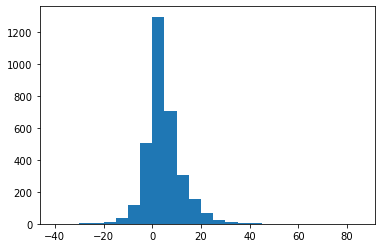

In [15]:
plt.hist(two_player_df['extra_actions'], bins=range(-40, 86, 5))
plt.show()

0.0040567465083281755

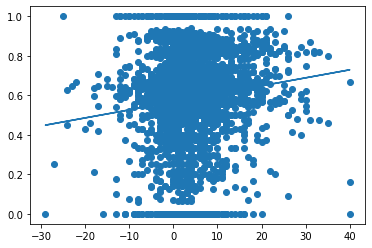

In [16]:
winner_win_ratio = []

for i in two_player_df.iloc():
    if i['north_part'] == i['winner']:
        winner_win_ratio.append(i['north_win_ratio'])
    else:
        winner_win_ratio.append(i['south_win_ratio'])
        
two_player_df['winner_win_ratio'] = winner_win_ratio

plt.scatter(two_player_df['extra_actions'], two_player_df['winner_win_ratio'])
m, b = np.polyfit(two_player_df['extra_actions'], two_player_df['winner_win_ratio'], 1)
plt.plot(two_player_df['extra_actions'], m * two_player_df['extra_actions'] + b)

m # Plot number of extra actions used by the winner compared to the win ratio of the winner.

(array([0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 8.000e+00, 1.900e+01,
        1.140e+02, 8.550e+02, 1.645e+03, 4.550e+02, 1.180e+02, 2.300e+01,
        7.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([-40, -35, -30, -25, -20, -15, -10,  -5,   0,   5,  10,  15,  20,
         25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85]),
 <a list of 25 Patch objects>)

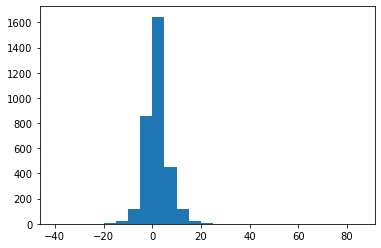

In [17]:
plt.hist(two_player_df['extra_builds'], bins=range(-40, 86, 5))

0.0061213449245956396

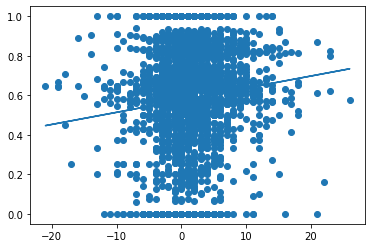

In [18]:
plt.scatter(two_player_df['extra_builds'], two_player_df['winner_win_ratio'])
m, b = np.polyfit(two_player_df['extra_builds'], two_player_df['winner_win_ratio'], 1)
plt.plot(two_player_df['extra_builds'], m * two_player_df['extra_builds'] + b)

m # Plot number of extra builds used by the winner compared to the win ratio of the winner.

Third, we investigated how popular different homeworld combinations were by creating a bar chart of the homeworld setup vs. its popularity as a north setup and south setup combined. We found that there were certain setups that were significantly more popular than others so we decided to use that as a basis for our hypothesis.

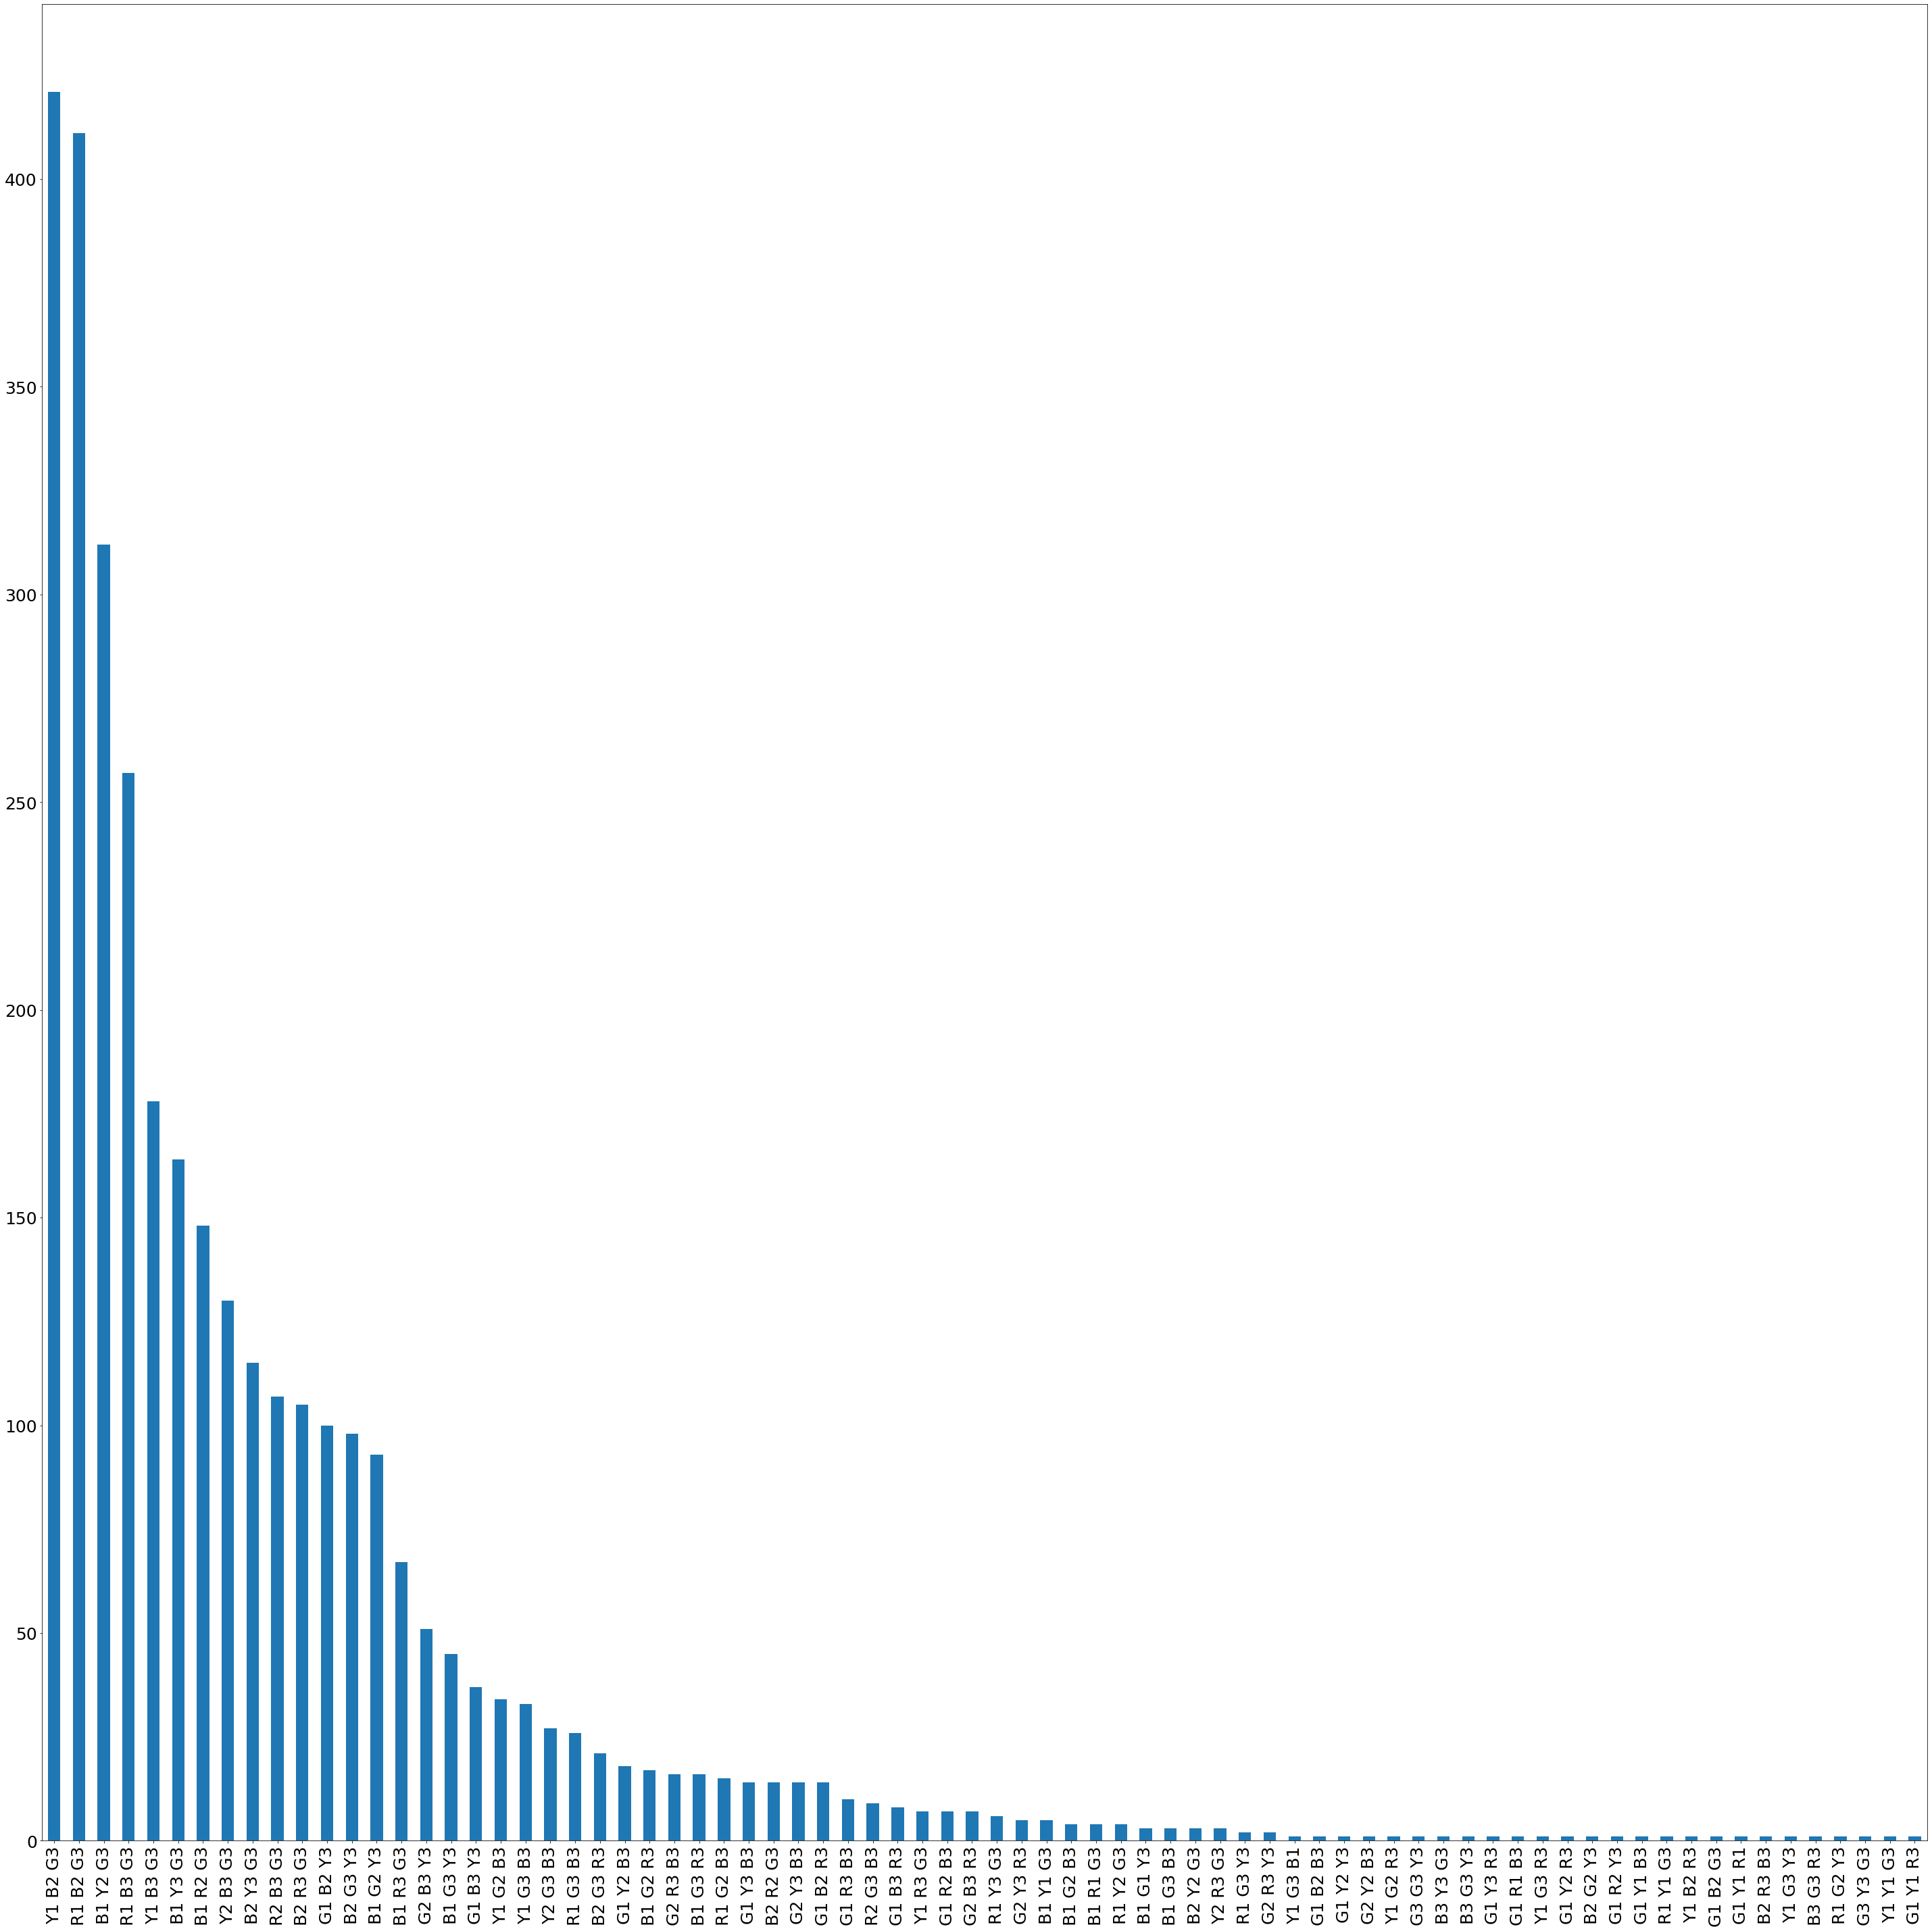

In [19]:
# Plot the popularity of different setups for the player who goes first.
two_player_df['north_hw'].value_counts().plot(kind='bar', figsize=(50,50), fontsize=25)

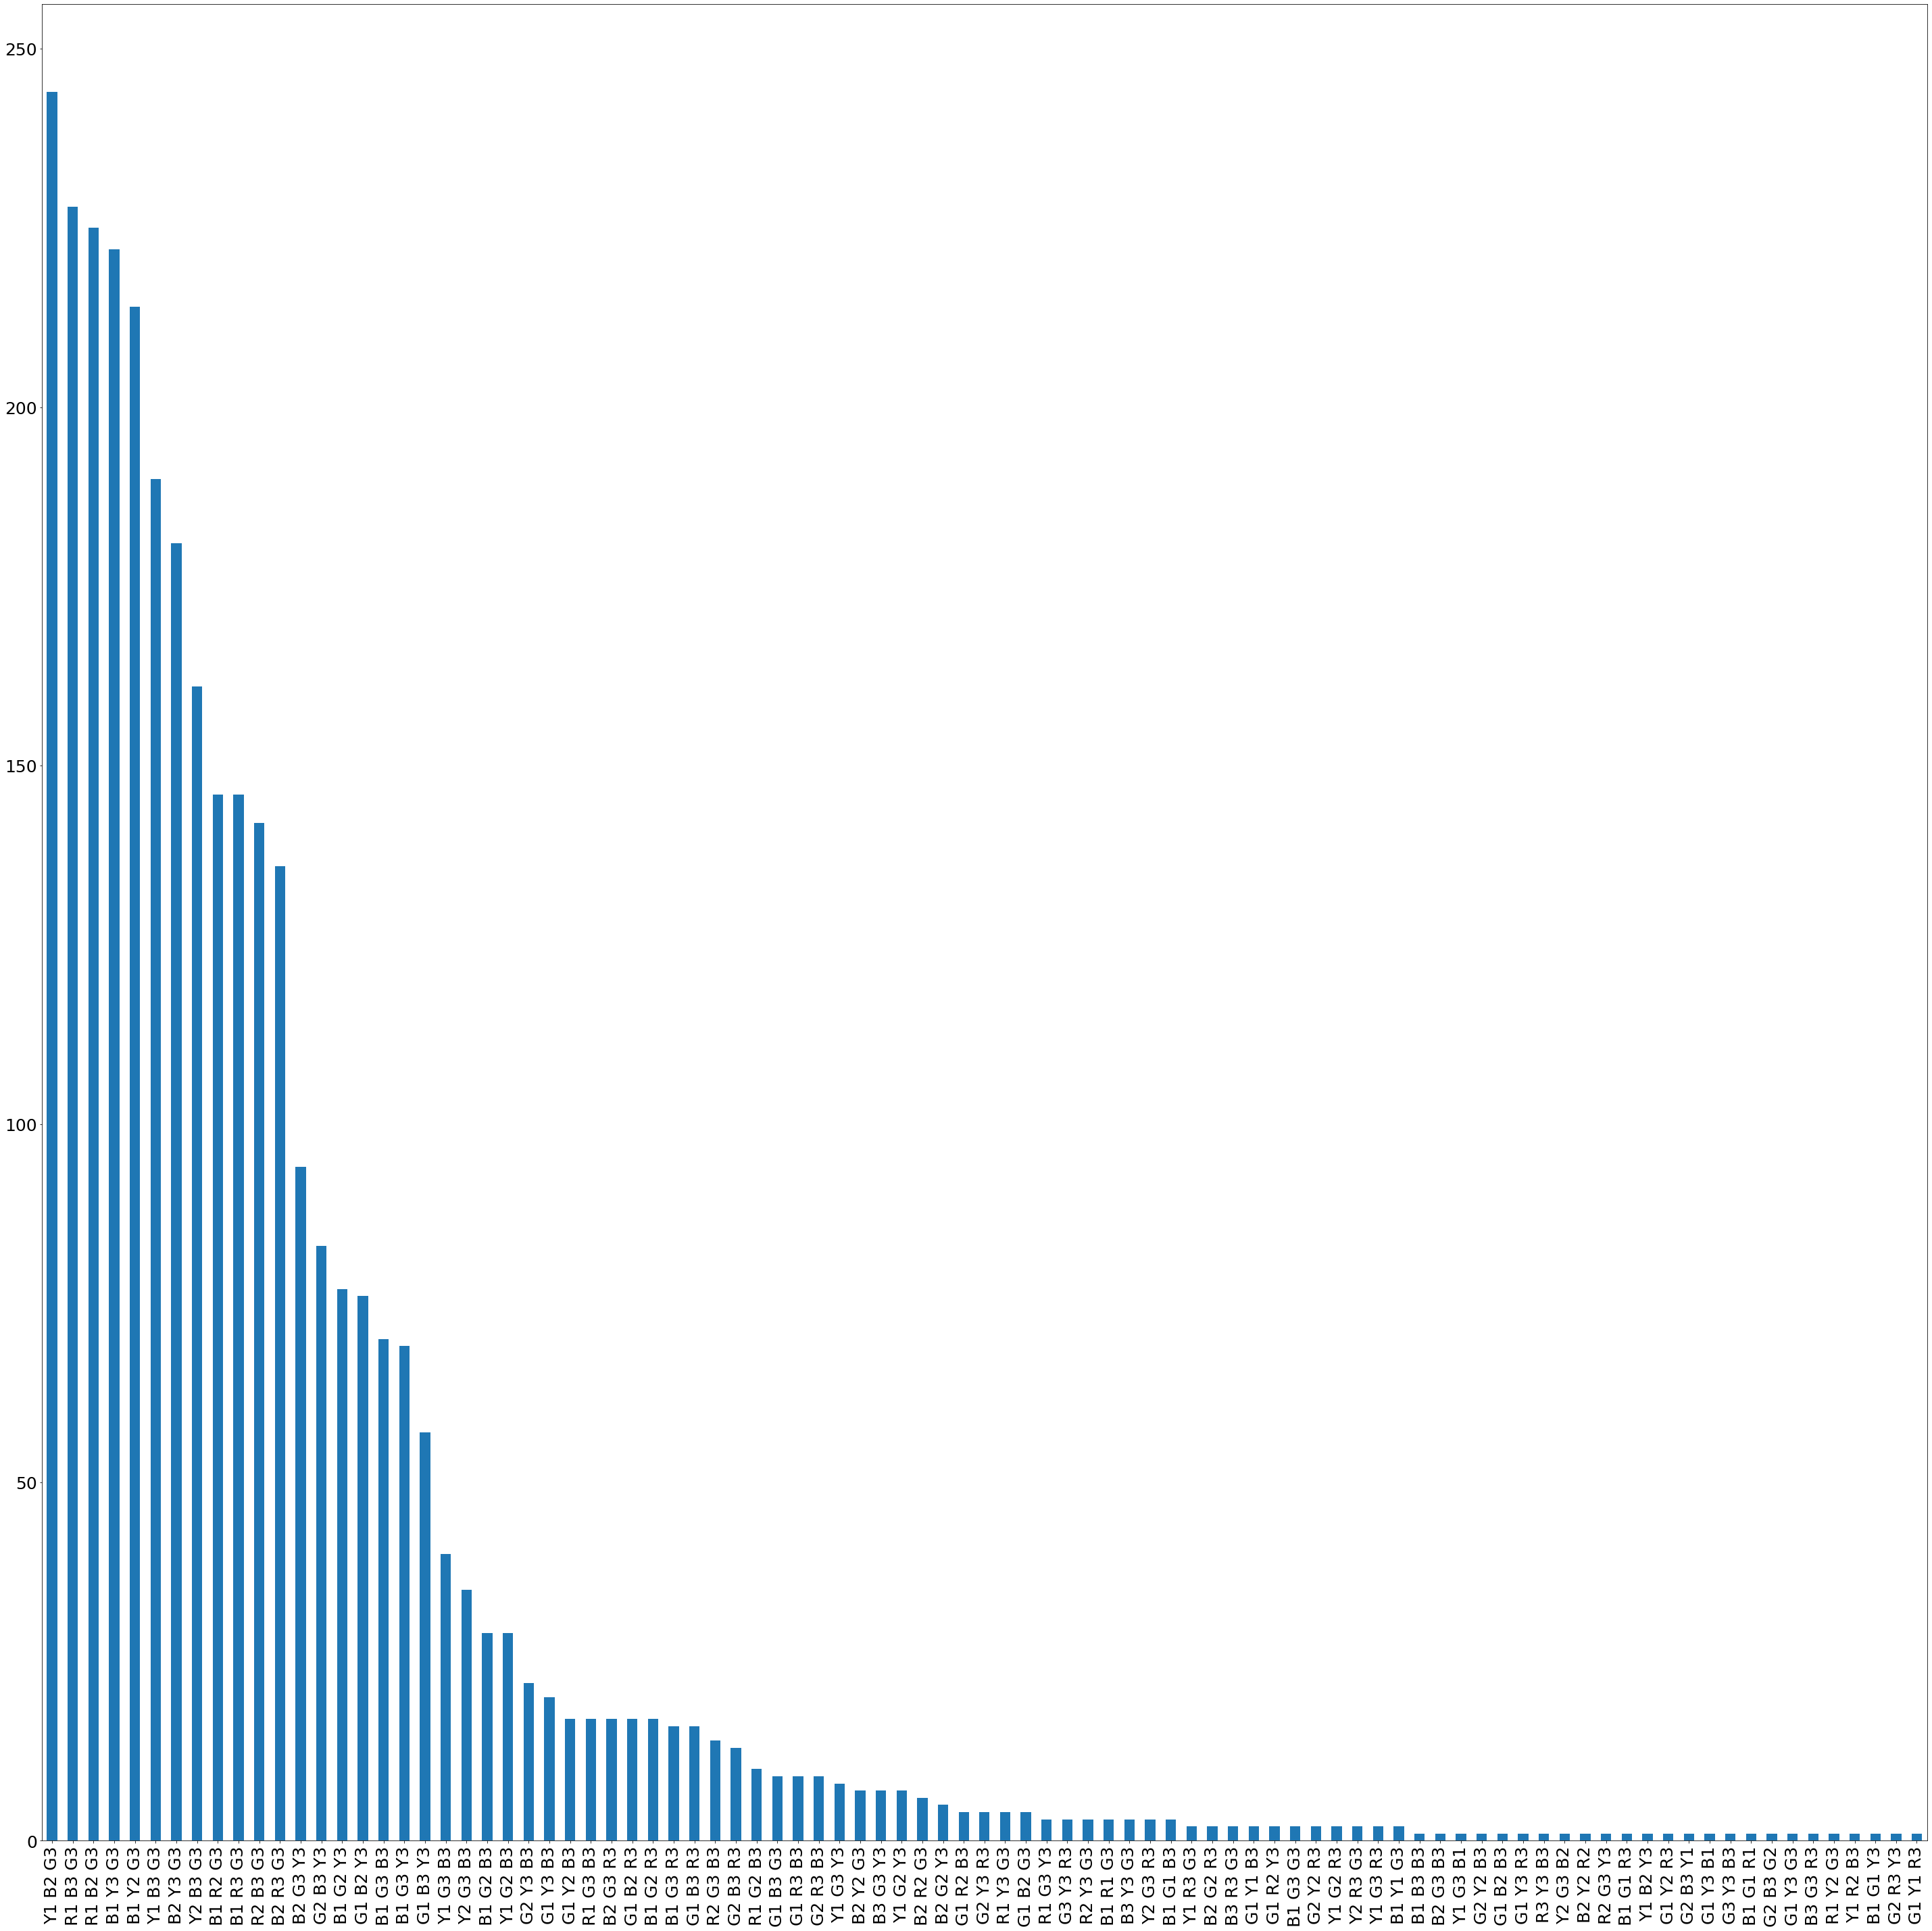

In [20]:
# Plot the popularity of different setups for the player who goes second.
two_player_df['south_hw'].value_counts().plot(kind='bar', figsize=(50,50), fontsize=25)

In [21]:
# Turn winner into an integer value: north wins = 1, north loses (south wins) = 0.
winner_loc = []

for i in two_player_df.iloc():
    if i['winner'] == i['north_part']:
        winner_loc.append(1) # North wins: 1
    else:
        winner_loc.append(0) # South wins: 0
        
two_player_df['winner_loc'] = winner_loc

two_player_df

,game_no,winner,num_turns,num_actions,south_part,north_part,south_actions,north_actions,south_hw,north_hw,...,south_num_games,north_num_games,north_num_wins,south_num_wins,north_win_ratio,south_win_ratio,extra_actions,extra_builds,winner_win_ratio,winner_loc
1,632,jesse,21,23,Subhan64,jesse,10,13,B2 Y2 R2,Y1 B2 G3,...,0,0,0,0,0.000000,0.000000,3,0,0.000000,1
2,627,CDRodeffer,63,82,Aaron,CDRodeffer,37,45,Y1 B3 G3,R1 Y2 G3,...,0,0,0,0,0.000000,0.000000,8,7,0.000000,1
3,644,jesse,36,66,jesse,rbryan,41,25,Y1 B2 G3,B2 Y3 G3,...,1,0,0,1,0.000000,1.000000,16,5,1.000000,0
4,625,Jesse,26,41,Jesse,jeep,17,19,B1 Y2 G3,G1 B3 Y3,...,0,0,0,0,0.000000,0.000000,-2,2,0.000000,0
6,636,MatrixFrog,67,83,Cerulean,MatrixFrog,36,47,G2 B3 Y3,G1 Y2 Y3,...,0,0,0,0,0.000000,0.000000,11,2,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,37124,Draw5PlayAll,25,28,Simon,Draw5PlayAll,14,14,B1 R1 G3,B2 R2 G3,...,95,129,73,66,0.565891,0.694737,0,-2,0.565891,1
4193,36765,Felix,28,31,Felix,dlwillson,16,15,B2 R3 G3,Y1 B3 G3,...,268,225,139,166,0.617778,0.619403,1,0,0.619403,0
4194,37066,wil,61,79,Felix,wil,37,42,B2 R3 G3,B1 Y2 G3,...,269,508,294,167,0.578740,0.620818,5,8,0.578740,1
4195,37068,Felix,40,44,Layana,Felix,23,21,B1 R2 G3,Y2 B3 G3,...,25,270,167,11,0.618519,0.440000,-2,-3,0.618519,1


## Hypothesis Testing and Maching Learning:
Because turn order, extra actions, and extra builds proved to have little to no effect on the outcome, we decided to try to predict the outcome of a game based on the starting setups. Starting setup is a categorical variable, so in order to convert the setup to a numerical value we decided to use each setup’s popularity. We first computed the popularity of each setup for North and South separately using the value_counts() method and combined this data using dictionaries so that we could compute overall popularity. We then tried to predict the winner of a game using the popularity of North’s setup and the popularity of South’s setup. 

We used 3-fold cross validation with logistic regression gradient descent, k-nearest neighbor, and decision tree classification, and calculated the average prediction error for each. We found that logistic regression gradient descent gave us an average error of about 0.56, meaning this model predicts the winner with about 44% accuracy. K-nearest neighbors gave us an average error of 0.451. Decision tree classification gave us an average error of 0.448.

In [22]:
# Defining log descent function
def log_descent(X,y,T,a):
    m,n=X.shape
    beta=np.zeros(n)
    loss=np.zeros(T)
    for i in range(T):
        f=X.dot(beta) # the ith "f of beta"
        p=(np.exp(f))/(1+np.exp(f)) # the ith "p of beta"
        beta=beta+(a*(y-p).dot(X)) # beta is then updated based on the give equation
        loss[i]=-((y*f)-(np.log(1+np.exp(f)))).sum()# The normal logistic regression loss function
    return beta,loss

In [23]:
# Calculate the popularities for either position of the homeworld setups.
setup_pop_dict = {}
north_setup_pop = two_player_df['north_hw'].value_counts()
south_setup_pop = two_player_df['south_hw'].value_counts()

for i in north_setup_pop.keys():
    if i in setup_pop_dict:
        setup_pop_dict[i] += north_setup_pop[i]
    else:
        setup_pop_dict[i] = north_setup_pop[i]
        
for i in south_setup_pop.keys():
    if i in setup_pop_dict:
        setup_pop_dict[i] += south_setup_pop[i]
    else:
        setup_pop_dict[i] = south_setup_pop[i]

In [34]:
# Add two new columns that contain the popularity of the north and south homeworlds (number of times they've been used in total).

north_hw_pop = []
south_hw_pop = []

two_player_df = two_player_df.dropna()

for i in two_player_df.iloc():
    north_hw_pop.append(setup_pop_dict[i['north_hw']])
    south_hw_pop.append(setup_pop_dict[i['south_hw']])
    
two_player_df['south_hw_pop'] = south_hw_pop
two_player_df['north_hw_pop'] = north_hw_pop

two_player_df

,game_no,winner,num_turns,num_actions,south_part,north_part,south_actions,north_actions,south_hw,north_hw,...,north_num_wins,south_num_wins,north_win_ratio,south_win_ratio,extra_actions,extra_builds,winner_win_ratio,winner_loc,south_hw_pop,north_hw_pop
1,632,jesse,21,23,Subhan64,jesse,10,13,B2 Y2 R2,Y1 B2 G3,...,0,0,0.000000,0.000000,3,0,0.000000,1,1,665
2,627,CDRodeffer,63,82,Aaron,CDRodeffer,37,45,Y1 B3 G3,R1 Y2 G3,...,0,0,0.000000,0.000000,8,7,0.000000,1,368,5
3,644,jesse,36,66,jesse,rbryan,41,25,Y1 B2 G3,B2 Y3 G3,...,0,1,0.000000,1.000000,16,5,1.000000,0,665,296
4,625,Jesse,26,41,Jesse,jeep,17,19,B1 Y2 G3,G1 B3 Y3,...,0,0,0.000000,0.000000,-2,2,0.000000,0,526,94
6,636,MatrixFrog,67,83,Cerulean,MatrixFrog,36,47,G2 B3 Y3,G1 Y2 Y3,...,0,0,0.000000,0.000000,11,2,0.000000,1,134,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4192,37124,Draw5PlayAll,25,28,Simon,Draw5PlayAll,14,14,B1 R1 G3,B2 R2 G3,...,73,66,0.565891,0.694737,0,-2,0.565891,1,7,20
4193,36765,Felix,28,31,Felix,dlwillson,16,15,B2 R3 G3,Y1 B3 G3,...,139,166,0.617778,0.619403,1,0,0.619403,0,241,368
4194,37066,wil,61,79,Felix,wil,37,42,B2 R3 G3,B1 Y2 G3,...,294,167,0.578740,0.620818,5,8,0.578740,1,241,526
4195,37068,Felix,40,44,Layana,Felix,23,21,B1 R2 G3,Y2 B3 G3,...,167,11,0.618519,0.440000,-2,-3,0.618519,1,294,291


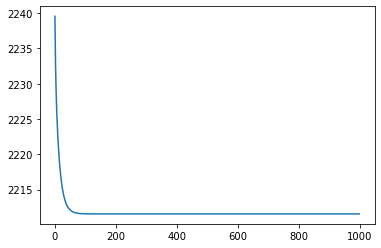

In [25]:
# Create a model using the popularity of the north and south homeworlds' popularities as variables and the winner location (north: 1, south: 0) as the experimental values.

X = []
y = []

for i in two_player_df.iloc():
    X.append([i['north_hw_pop']/100, i['south_hw_pop']/100])
    y.append(i['winner_loc'])

X = np.array(X)
y = np.array(y)

beta, loss = log_descent(X, y, 1000, 0.00001)

plt.plot(loss)
plt.show()

In [26]:
# Calculate the total losses based on the total absolute difference between the experimental and estimated values.
total = 0
count = 0

for i, r in enumerate(X):
    total += np.absolute(y[i] - r.dot(beta))
    count += 1

total/count

0.5573332465337574

In [27]:
# Guess the size based on 
knn=KNeighborsClassifier(n_neighbors=40)
knn.fit(X,y)
knn.predict(X)[0]
count=0
    
for r, x in enumerate(knn.predict(X)):
    if(x==y[r]):
        count+=1
        
count/y.size # Return the average number of correct predictions

0.6087898483441659

In [28]:
# Second, Decision Tree Classifier with gini for determining the best split
cTree=tree.DecisionTreeClassifier()
cTree=cTree.fit(X,y)
count=0
for r,x in enumerate(cTree.predict(X)):
    if(x==y[r]):
        count+=1
        
(count/y.size) # Average number of correct predictions

0.6945218198700093

After we calculated the average prediction error for each method, we ran a left-tailed z-test (H0: avg. error = 0.48; Ha: avg. error < 0.48, $\alpha$ = 0.05 ). Our null hypothesis states that the mean error is equal to the compliment of the ratio of north wins to total games. Our alternative hypothesis states that the standard mean is less than the compliment of the ratio of north wins to total wins. Basically, we are trying to test if the models can predict with more accuracy than just guessing based on the ratio. Our calculated p-values are (Note: these change because of the nature of 3-fold cross-val.): 
 - logistic Regression => 0.9973
 - Decision Tress => 0.0547
 - K Nearest-Neighbor => 0.0655
 
None of these reject the null hypothesis based on a significance value of 0.05. Thus we can conclude that there is not evidence that (based on these three models) you can repeatedly predict the outcome of a game based on homeworld setup alone.

In [29]:
# Finally, we use 3-fold cross-validation to test the predictions

# Start by defining relevant variables
num_fold = 3

m, n= X.shape
step = int(m / num_fold)

start = 0
end = 0

lr_mean = 0
lr_means = []
lr_se = []

dtc_mean = 0
dtc_means = []
dtc_se = []

knn_mean = 0
knn_means = []
knn_se = []

# 3 times...
for i in range(num_fold):
    if(start + step > m):
        end = len(two_player_df)
    else:
        end = start + step
        
    test = []
    train = []
    ytest = []
    ytrain = []
    
    # Split the data into groups, isolate the test set, and then train on the remaining data
    for j in range(m):
        if (j < start):
            train.append(X[j])
            ytrain.append(y[j]) 
        if(j >= start and j < end):
            test.append(X[j]) 
            ytest.append(y[j])
        if(j >= end):
            train.append(X[j])
            ytrain.append(y[j])
            
    start = end
            
    test = np.array(test)
    train = np.array(train)
    ytest = np.array(ytest)
    ytrain = np.array(ytrain)
    
    # Next, we get the mean error of logistic regression,...
    total = 0
    beta, f = log_descent(train, ytrain, 1000, 0.00001)
    a,b = test.shape
    for k in range(a):
        p = test[k].dot(beta)
        total += np.absolute(ytest[k] - p)
    lr_mean += total/ytest.size
    lr_means.append(total/ytest.size)
    
    # ...the mean error for the decision tree classifier,...
    dtc = tree.DecisionTreeClassifier()
    dtc = dtc.fit(train, ytrain)
    total = 0
    for k,p in enumerate(dtc.predict(test)):
        total += np.absolute(ytest[k] - p)
    dtc_mean += total/ytest.size
    dtc_means.append(total/ytest.size)
    
    #...and finally calculate our mean error for KNN
    knn = KNeighborsClassifier()
    knn.fit(train, ytrain)
    total = 0
    for k,p in enumerate(knn.predict(test)):
        total += np.absolute(ytest[k] - p)
    knn_mean += total/ytest.size
    knn_means.append(total/ytest.size)
    
# Calculate the average means for 3-fold cross val and the standard error
lr_mean = round(lr_mean/num_fold, 3)
dtc_mean = round(dtc_mean/num_fold, 3)
knn_mean = round(knn_mean/num_fold, 3)
for i in range(num_fold):
    l = lr_means[i] - lr_mean
    lr_se.append(np.sqrt(l*l))  
    
    d = dtc_means[i] - dtc_mean
    dtc_se.append(np.sqrt(d*d))
    
    k = knn_means[i] - knn_mean
    knn_se.append(np.sqrt(k*k))   
    
lr_SE = round(np.sqrt(np.sum(lr_se)/(num_fold-1))/np.sqrt(num_fold), 3)
dtc_SE = round(np.sqrt(np.sum(dtc_se)/(num_fold-1))/np.sqrt(num_fold), 3)
knn_SE = round(np.sqrt(np.sum(knn_se)/(num_fold-1))/np.sqrt(num_fold), 3)

# Return the results
"lr mean: " + str(lr_mean) + " dtc mean: " + str(dtc_mean) + " knn mean: " + str(knn_mean)

'lr mean: 0.56 dtc mean: 0.459 knn mean: 0.456'

In [30]:
"lr SE: " + str(lr_SE) + " dtc SE: " + str(dtc_SE) + " knn SE: " + str(knn_SE)

'lr SE: 0.139 dtc SE: 0.088 knn SE: 0.099'

In [31]:
ztest, pval = stests.ztest(lr_means, value=(1-north_win_ratio), alternative='smaller')

pval

0.9973298565954031

In [32]:
ztest, pval = stests.ztest(dtc_means, value=(1-north_win_ratio), alternative='smaller')

pval

0.054738411961178374

In [33]:
ztest, pval = stests.ztest(knn_means, value=(1-north_win_ratio), alternative='smaller')

pval

0.06554514028360195

## Insights:
Despite testing various parameters for their influence on the outcome of the game, we could not consistently predict the outcome of a game based on simple factors such as homeworld setup or times that a player did a certain move. This is as expected. Based on the fact that this is an asymetric(has no features based on luck, i.e. no dice, spinner, etc.) game of strategy. The game is meant to be won by the player who better thinks out their position so we cannot expect to be able to predict the winner with a significant degree of accuracy. Factors such as going first or choosing a more popular setup may give a player a slight advantage, but this advantage will not be significant enough to effect the fairness of the game and ultimately will not control the outcome of the game.
    
## Additional Resource:
For additional information, consider the game rules, a video explaining the game, and an article on solving chess. While chess and homeworlds have very different mechanics, they are both two-player games of strategy and therefore are comparable. 

Game Rules: http://www.ginohn.com/wunder201005/games/Homeworlds/HomeworldsRules.html
Video Explanation: https://youtu.be/Nz16s6oCIlQ
Solving Chess: https://en.wikipedia.org/wiki/Solving_chess

First Move Advantage in Chess: https://en.wikipedia.org/wiki/First-move_advantage_in_chess

Pictures:
https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.Ls41ul_5ajHuyCi-QVekMAHaHa%26o%3D6%26pid%3DApi&f=1

https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fi.ytimg.com%2Fvi%2FNz16s6oCIlQ%2Fmaxresdefault.jpg&f=1&nofb=1